In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, f1_score
import numpy as np
import re
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D

In [2]:
# Load dataset
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')


# Simple text preprocessing function
def preprocess_text(s):
    # Lowercase text
    s = s.lower()
    # Replace URLs with a space in the message
    s = re.sub(r'http\S+', ' ', s)
    # Replace ticker symbols with a space
    s = re.sub(r'\$\w*', ' ', s)
    # Replace everything not a letter or apostrophe with a space
    s = re.sub(r'[^a-z\']', ' ', s)
    # Remove single letter words
    s = re.sub(r'\s+[a-z]\s+', ' ', s)
    # Remove multiple spaces with a single space
    s = re.sub(r'\s+', ' ', s)
    return s.strip()


# Select a subset of the dataset
train_data_selected = train_data[:8500]
test_data_selected = test_data[:3600]

# Split into training and validation sets
train_texts, val_texts, train_targets, val_targets = train_test_split(train_data_selected['text'], train_data_selected['target'], test_size=0.1)


# Apply preprocessing to text data
train_texts = train_texts.apply(preprocess_text)
val_texts = val_texts.apply(preprocess_text)
test_texts = test_data['text'].apply(preprocess_text)


# Tokenization
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(train_texts)

# Convert texts to sequences
train_sequences = tokenizer.texts_to_sequences(train_texts)
val_sequences = tokenizer.texts_to_sequences(val_texts)
test_sequences = tokenizer.texts_to_sequences(test_data['text'])

# Pad the sequences to ensure uniform length
max_len = 128
train_padded = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=max_len)
val_padded = tf.keras.preprocessing.sequence.pad_sequences(val_sequences, maxlen=max_len)
test_padded = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=max_len)


#CNN model
input_layer = Input(shape=(max_len,))
embedding_layer = tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=50, input_length=max_len)(input_layer)
conv_layer = Conv1D(filters=64, kernel_size=3, activation='relu')(embedding_layer)
pooling_layer = GlobalMaxPooling1D()(conv_layer)
dropout_layer = Dropout(0.3)(pooling_layer)
output_layer = Dense(1, activation='sigmoid')(dropout_layer)

model = Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer=Adam(learning_rate=5e-5), loss='binary_crossentropy', metrics=['accuracy'])


model.fit(train_padded, train_targets, batch_size=16, epochs=3, validation_data=(val_padded, val_targets))


Epoch 1/3
429/429 [==============================] - 8s 16ms/step - loss: 0.6875 - accuracy: 0.5513 - val_loss: 0.6801 - val_accuracy: 0.5722
Epoch 2/3
429/429 [==============================] - 6s 15ms/step - loss: 0.6759 - accuracy: 0.5745 - val_loss: 0.6740 - val_accuracy: 0.5722
Epoch 3/3
429/429 [==============================] - 7s 15ms/step - loss: 0.6673 - accuracy: 0.5777 - val_loss: 0.6683 - val_accuracy: 0.5748


In [3]:
val_predictions = model.predict(val_padded)
val_predictions = [1 if p > 0.5 else 0 for p in val_predictions]

precision, recall, f1, _ = precision_recall_fscore_support(val_targets, val_predictions, average='weighted')
print(f'Validation Precision: {precision:.4f}')
print(f'Validation Recall: {recall:.4f}')
print(f'Validation F1 Score: {f1:.4f}')


24/24 [==============================] - 0s 3ms/step
Validation Precision: 0.7561
Validation Recall: 0.5748
Validation F1 Score: 0.4224


In [4]:
# Function to make predictions on the test set
def predict(model, test_padded):
    predictions = model.predict(test_padded)
    # Converting predictions to binary classification
    predictions = [1 if p > 0.5 else 0 for p in predictions]
    return predictions

# Make predictions on test data
test_preds = predict(model, test_padded)

submission = pd.DataFrame({'id': test_data['id'], 'target': test_preds})

# Save the submission file
submission.to_csv('submission_CNN.csv', index=False)

print("Submission file saved as 'submission_CNN.csv'")


102/102 [==============================] - 0s 2ms/step
Submission file saved as 'submission_CNN.csv'


24/24 [==============================] - 0s 4ms/step


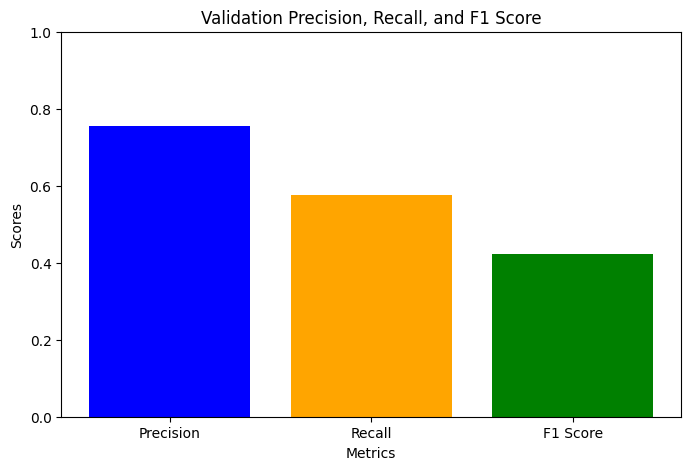

24/24 [==============================] - 0s 2ms/step


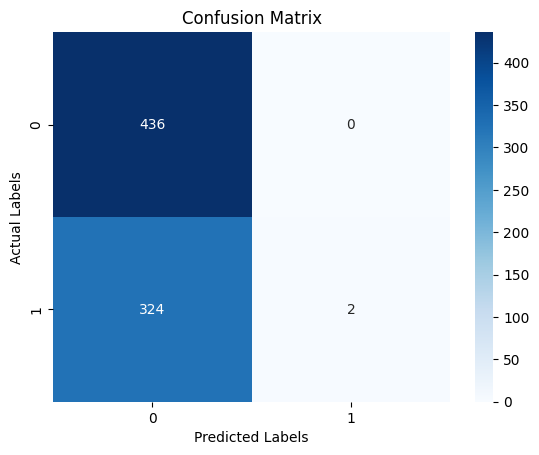

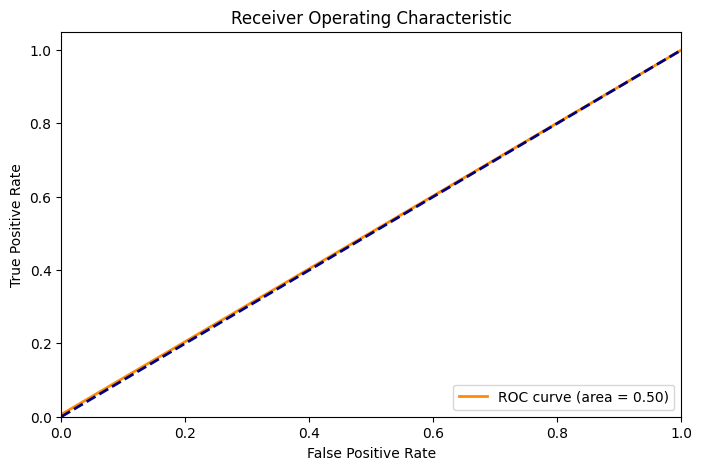

In [5]:
# Function to evaluate the model (precision, recall, F1)
def evaluate(model, val_padded, val_targets):
    val_predictions = model.predict(val_padded)
    val_predictions = [1 if p > 0.5 else 0 for p in val_predictions]

    precision, recall, f1, _ = precision_recall_fscore_support(val_targets, val_predictions, average='weighted')
    return precision, recall, f1

# Calculate precision, recall, and F1 score
precision, recall, f1 = evaluate(model, val_padded, val_targets)

# Plot Precision, Recall, and F1 Score
plt.figure(figsize=(8, 5))
metrics = [precision, recall, f1]
metric_names = ['Precision', 'Recall', 'F1 Score']
plt.bar(metric_names, metrics, color=['blue', 'orange', 'green'])
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Validation Precision, Recall, and F1 Score')
plt.ylim(0, 1)  
plt.show()

# Confusion Matrix
val_predictions = model.predict(val_padded)
val_predictions = [1 if p > 0.5 else 0 for p in val_predictions]

cm = confusion_matrix(val_targets, val_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(val_targets, val_predictions)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


In [1]:
# Values from the new confusion matrix
TP = 2
TN = 436
FP = 0
FN = 324

# Total number of samples
total = TP + TN + FP + FN

# Calculate accuracy
accuracy = (TP + TN) / total

# Print
accuracy_formula = f'Accuracy = (TP + TN) / (TP + TN + FP + FN) = ({TP} + {TN}) / ({TP} + {TN} + {FP} + {FN})'
print(accuracy_formula)
print(f'Calculated Accuracy: {accuracy:.4f}')


Accuracy = (TP + TN) / (TP + TN + FP + FN) = (2 + 436) / (2 + 436 + 0 + 324)
Calculated Accuracy: 0.5748
